## Codice usando i dati presenti nel  [paper(pag 18, paragrafo 4.2)](https://drive.google.com/file/d/1YBFS7FW81_pyuryAb5ISiofgLkT7Gp-P/view?usp=sharing).

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
from utils import *
import numpy as np 
from dwave.system import DWaveSampler, EmbeddingComposite, DWaveCliqueSampler
import dimod
import dwave.inspector
import pickle

In [2]:
mu0 = 0.0
var0 = 1

x = np.array([-2.296, -0.216, -0.082, 0.231, 1.127, 1.164, 1.189, 1.236, 1.272, 1.373])

In [3]:
Nodes = [f'a{i}' for i in range(-7, 2)] + [f'b{i}' for i in range(-7, 2)]

C_G = nx.complete_graph(Nodes)

In [4]:
bqm = dimod.BinaryQuadraticModel.empty(dimod.BINARY)

for i, node in enumerate(C_G.nodes):
    if node[0] == 'a':
        p = int(node[1:])
        w = -np.sum(2**p * fA(x, mu0, var0) + (2**(2*p - 1) - 2**p*mu0)*fAA(var0) - 2**p*var0*fAB(x, mu0, var0))
        
        bqm.add_variable(v=node, bias=w)
    else:
        p = int(node[1:])
        w = -np.sum(2**p * fB(x, mu0, var0) + (2**(2*p - 1) - 2**p*var0)*fBB(x, mu0, var0) - 2**p*var0*fAB(x, mu0, var0))
        
        bqm.add_variable(v=node, bias=w)

In [5]:
A = []
B = []
AB = []

link_A, link_B, link_AB = 0, 0, 0

for edge in C_G.edges:
    node1, node2 = edge
    if node1[0] == node2[0] == 'a':
        pi = int(node1[1:])
        pj = int(node2[1:])
        w = -2**(pi+pj)*fAA(var0)
        
        link_A += 1
        A.append(w)
        bqm.add_interaction(node1, node2, w)
        
    elif node1[0] == node2[0] == 'b':
        pi = int(node1[1:])
        pj = int(node2[1:])
        w = -np.sum(2**(pi+pj)*fBB(x, mu0, var0))
        
        link_B += 1
        B.append(w)
        bqm.add_interaction(node1, node2, w)
        
    else:
        pi = int(node1[1:])
        pj = int(node2[1:])
        w = -np.sum(2**(pi+pj)*fAB(x, mu0, var0))
        
        link_AB += 1
        AB.append(w)
        bqm.add_interaction(node1, node2, w)

In [6]:
link_A, link_B, link_AB

(36, 36, 81)

In [7]:
np.sum(-(x-mu0)**2/(var0)**2)

-14.447911999999999

In [30]:
sampleset = EmbeddingComposite(DWaveSampler()).sample(bqm, num_reads=1000, chain_strength=0) #

In [31]:
lowest_state = sampleset.lowest().record[0][0]
mu, var = 0, 0

for i, sol in enumerate(lowest_state):
        p = int(sampleset.variables[i][1:])
        if sampleset.variables[i][0] == 'a':
            mu = mu + 2**(p) * sol
        else:
            var = var + 2**(p) * sol
            
mu, var

(0.3671875, 1.4140625)

In [32]:
theta = np.zeros(len(sampleset.record))
phi = np.zeros(len(sampleset.record))

for k, rec in enumerate(sampleset.record):
    states = rec[0]
    mu = 0
    var = 0
    for i, sol in enumerate(states):
        p = int(sampleset.variables[i][1:])
        if sampleset.variables[i][0] == 'a':
            mu = mu + 2**(p) * sol
        else:
            var = var + 2**(p) * sol
            
    theta[k] = mu
    phi[k] = var

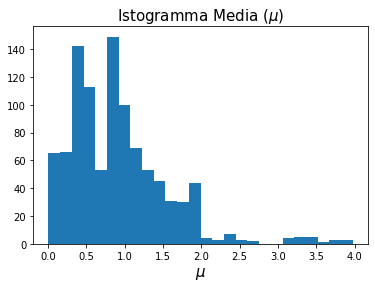

In [33]:
plt.hist(theta, bins='auto');
plt.xlabel('$\mu$', fontdict={'fontsize': 15})
plt.title('Istogramma Media ($\mu$)', fontdict={'fontsize':15})
plt.savefig('media.png')

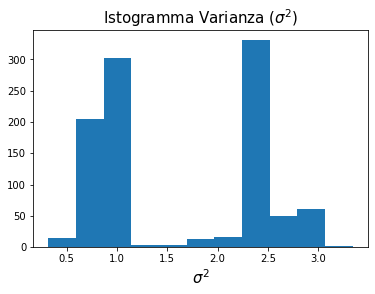

In [34]:
plt.hist(phi, bins='auto')
plt.xlabel('$\sigma^2$', fontdict={'fontsize': 15})
plt.title('Istogramma Varianza ($\sigma^2$)', fontdict={'fontsize':15})
plt.savefig('varianza.png')

In [35]:
dwave.inspector.show(sampleset)

'http://127.0.0.1:18000/?problemId=cdb7b6a0-14a1-4583-ab0a-3a43cf9a9187'